# Face Recognition #6

- We are using: FaceRecs
- We are performing new embeddings for each video to find matches
- We are using tolerance = 0.4 and threshold = 0.65

In [1]:
import argparse
import pickle
import cv2
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os
import dlib
import matplotlib.pyplot as plt
import numpy as np
import time

print(dlib.DLIB_USE_CUDA)
#dlib.DLIB_USE_CUDA = True

True


In [2]:
def faceRecognition(image, encodings, detection='cnn', show=False, tolerance = 0.6):
    start = time.time()
    # the image is already converted in an rgb format
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # format used by openCV
    data = encodings

    # detect the (x, y)-coordinates of the bounding boxes corresponding
    # to each face in the input image, then compute the facial embeddings
    # for each face
    boxes = face_recognition.face_locations(rgb,model=detection)
    encodings = face_recognition.face_encodings(rgb, boxes)

    # initialize the list of names for each face detected
    names = []

    # loop over the facial embeddings
    for encoding in encodings:
        # attempt to match each face in the input image to our known
        # encodings
        matches = face_recognition.compare_faces(data["encodings"], encoding, tolerance = tolerance)
        name = "unknown"

        # check to see if we have found a match
        if True in matches:
            # find the indexes of all matched faces then initialize a
            # dictionary to count the total number of times each face
            # was matched
            matchedIdxs = [i for (i, b) in enumerate(matches) if b]
            counts = {}

            # loop over the matched indexes and maintain a count for
            # each recognized face face
            for i in matchedIdxs:
                name = data["names"][i]
                counts[name] = counts.get(name, 0) + 1

            # determine the recognized face with the largest number of
            # votes (note: in the event of an unlikely tie Python will
            # select first entry in the dictionary)
            name = max(counts, key=counts.get)

        # update the list of names
        try:
            name = name.split('/')[2]
        except:
            name = name
        names.append(name)

    # loop over the recognized faces
    for ((top, right, bottom, left), name) in zip(boxes, names):
        # draw the predicted face name on the image
        cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
        y = top - 15 if top - 15 > 15 else top + 15
        cv2.putText(image, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
            0.75, (0, 255, 0), 2)
    
    
    stop = time.time()
    #print('Time needed:', stop-start, 'sec')
    # show the output image
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if(show== True):
        print(names)
        plt.imshow(rgb)
        plt.show()
    return names

def imageRead(path, show=True):
    # BGR FORMAT #
    image = cv2.imread(path)
    
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if(show== True):
        plt.imshow(rgb)
        plt.show()
    return image
    comp
def encodingsRead(path):
    ## PAY ATTENTION:: You need to create the encoding for you dataset using encode_face.py
    data = pickle.loads(open(path, "rb").read())
    return data

In [3]:
def faceRecOnFolder(dataset_folder, encodings, correct_person, detection='cnn', min_threshold = 0.85, 
                    max_threshold=0.10, tolerance = 0.6, stopping_perc = 50, show=False):
    imagePaths = list(paths.list_images(dataset_folder))

    analysed_frames = 0
    correct_frames = 0
    negative_frames = 0
    neutrum_frames = 0
    total_frames = len(imagePaths)
    start = time.time()
    
    min_frames = total_frames * stopping_perc / 100
    # grab the paths to the input images in our dataset
    print("[INFO] Recognizing faces...")
    print("[INFO] elements:", total_frames)

    # loop over the image paths
    for (i, imagePath) in enumerate(imagePaths):
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
        image = imageRead(imagePath, show=False)
        person_rec = faceRecognition(image, encodings, detection='cnn', tolerance = tolerance, show=show)
        analysed_frames += 1
        
        if(len(person_rec) >= 1):
            person = person_rec[0]
            if(person == correct_person):
                correct_frames += 1
            else:
                if(person == 'unknown'):
                    neutrum_frames += 1
                else:
                    negative_frames += 1
        else:
            neutrum_frames += 1
        
            
        if( analysed_frames > min_frames and correct_frames/analysed_frames > min_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            end = time.time()
            print('Time:', end-start)
            return True, correct_rate, neutrum_rate, negative_rate
        
        ######################## MODIFIED HERE
        # wrong recognition are interpreted as correspondent for this case
        #######################
        if( analysed_frames > min_frames and negative_frames/analysed_frames > min_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            end = time.time()
            print('Time:', end-start)
            return True, correct_rate, neutrum_rate, negative_rate
        
        if( analysed_frames > min_frames and (negative_frames+correct_frames)/analysed_frames < max_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            end = time.time()
            print('Time:', end-start)
            return False, correct_rate, neutrum_rate, negative_rate
        
        #########################
        
    #for ends
    if(total_frames == 0):
        total_frames = 1
    correct_rate = correct_frames/total_frames
    neutrum_rate = neutrum_frames/total_frames
    negative_rate = negative_frames/total_frames
    end = time.time()
    print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/total_frames)
    print('Not detected:', neutrum_frames/total_frames, ". Wrong recognition:", negative_frames/total_frames)
    print('Time:', end-start)
    if(correct_rate > min_threshold - 0.05):
        return True, correct_rate, neutrum_rate, negative_rate
    else:
        return False, correct_rate, neutrum_rate, negative_rate

#### Encodings generation
Let's build new encodings for each persons.
We will choose 20 as number of encs for each person to train; 100 as number of encodings for each person to test.

For this reasons we modify the existing function to take a random and limited number of pictures for reach person.
However we won't use it.

In [4]:
import random
root_path = "./"
num = 30
base_path = './videos/'

In [5]:
def createEncodingsFromVector(dataset_vector, name , detection = 'cnn'):

    # grab the paths to the input images in our dataset
    print("[INFO] quantifying faces...")
    '''
    We're going to take only a limit number of images to create the encodings.
    We'll take a random sample over all the images of a person and in particular
    '''
    if len(dataset_vector )<= 0:
        print("AN ERROR OCCURRED FOR ",name)
        return

    images = random.choices(dataset_vector, k = num, )

    # initialize the list of known encodings and known names
    knownEncodings = []
    knownNames = []
    # loop over the image paths
    for image in images:
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))

        # load the input image and convert it from RGB (OpenCV ordering)
        # to dlib ordering (RGB)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # detect the (x, y)-coordinates of the bounding boxes
        # corresponding to each face in the input image
        boxes = face_recognition.face_locations(rgb,model=detection)

        # compute the facial embedding for the face
        encodings = face_recognition.face_encodings(rgb, boxes)

        # loop over the encodings
        for encoding in encodings:
            # add each encoding + name to our set of known names and
            # encodings
            knownEncodings.append(encoding)
            knownNames.append(name)
    #pdb.set_trace()
    # dump the facial encodings + names to disk
    print("[INFO] serializing encodings..." + name)
    data = {"encodings": knownEncodings, "names": knownNames}
    file_name = root_path + "encodings_" + str(num) + "/" + name + '.pkl'
    
    print(len(knownEncodings))

    log_errors = False
    if( log_errors == True):
        if len(knownEncodings) > 25:
            f = open(root_path + "/encodings_face_videos/" + 'multiple_people.txt', 'a')
            f.write(name + '\n')
            f.close()
        if len(knownEncodings) <= 0:
            f = open(root_path + "/encodings_face_videos/" + 'not_recognisable.txt', 'a')
            f.write(name + '\n')
            f.close()
      

    f = open(file_name, "wb")
    f.write(pickle.dumps(data))
    f.close()

In [6]:
def readFrames(path):

    video = cv2.VideoCapture(path)
    count = 0
    frames = []
    while(1):
        ret, frame = video.read()
        if ret == True:
            frames.append(frame)
            count += 1
        else:
            break

    return frames

In [34]:
videos = os.listdir(base_path)
global_start = time.time()
count = 0

for video_name in videos:
    start = time.time()
    frames = readFrames(base_path + video_name)
    createEncodingsFromVector(frames,video_name)
    end = time.time()
    count += 1
    print(count/len(videos), 'Time_enc:', end-start)


global_end = time.time()
print('Time_enc:', global_end-global_start)

[INFO] quantifying faces...
[INFO] serializing encodings...rec-0048614e-6977-420f-96b9-2669e01b7b6a-xtlT3wU8hU-qR5OTs6cT0MYV1dP-1583832656032-video-face.webm
255
0.002824858757062147 Time_enc: 97.48454451560974
[INFO] quantifying faces...
[INFO] serializing encodings...rec-00f2215a-653a-41b0-a2bd-e081c2644b50-G9pr1rwdts-NHrbOczHA28ELIx0-1582012854590-video-face.webm
104
0.005649717514124294 Time_enc: 67.78190517425537
[INFO] quantifying faces...
[INFO] serializing encodings...rec-0158e178-671c-4f00-9d2c-4beb850fee5e-3JMlpKKcQI-AbKReuhN2e8lPpWU-1580377499206-video-face.webm
100
0.00847457627118644 Time_enc: 94.15358853340149
[INFO] quantifying faces...
[INFO] serializing encodings...rec-02775db9-2e4d-491a-ba5d-43fb715e0c3d-FA8nx738TZ-K7Nm6zOMFD0Q33Pc-1580810763795-video-face.webm
100
0.011299435028248588 Time_enc: 59.8850359916687
[INFO] quantifying faces...
[INFO] serializing encodings...rec-029c7345-eb65-4b22-aa68-4c7ad814ec4a-YYWgaS5LEb-Wfw34uhRwl8rKOAa-1582738555620-video-face.webm


[INFO] serializing encodings...rec-1a8c6bed-ebb0-4167-9c86-293d5fc5a12c-84pDQjlMXW-0P9fuZjlChhk0vDE-1582559205412-video-face.webm
100
0.11299435028248588 Time_enc: 80.02487897872925
[INFO] quantifying faces...
[INFO] serializing encodings...rec-1bfffc4c-678a-48fa-9d53-d17e8d71c9a1-1Y2XAnvhCP-tL8XWbXPrbmVowyg-1579697128993-video-face.webm
132
0.11581920903954802 Time_enc: 54.252854347229004
[INFO] quantifying faces...
[INFO] serializing encodings...rec-1c1ab680-70ce-41b2-915d-bb6c50d57cb6-6stHYiMeSE-ZHXAqo90xJlRjwXF-1580747229480-video-face.webm
100
0.11864406779661017 Time_enc: 76.73193430900574
[INFO] quantifying faces...
[INFO] serializing encodings...rec-1c1bf933-835b-49fd-a178-9ee0fefacc96-mYycDX0R3l-Rbg5Jfnaqje4NlcA-1581442309680-video-face.webm
97
0.12146892655367232 Time_enc: 76.37265038490295
[INFO] quantifying faces...
[INFO] serializing encodings...rec-1c3504ca-e652-40c2-8b77-1cd16174919b-oVcNnjQBu9-QlrzRM1VWHAZUKxU-1581443193377-video-face.webm
100
0.12429378531073447 Time_e

[INFO] quantifying faces...
[INFO] serializing encodings...rec-32e61d8e-df52-48b2-b7a8-f7475c924690-E3qO5VOmIG-MGDSq50usWakuoP4-1580308985665-video-face.webm
100
0.22598870056497175 Time_enc: 84.75557494163513
[INFO] quantifying faces...
[INFO] serializing encodings...rec-33ef9576-1aaf-42bd-9efc-6341a1ff3fe3-Dquk8t8vFJ-a1ptgtuq6SniNgN3-1580226977654-video-face.webm
100
0.2288135593220339 Time_enc: 58.0362491607666
[INFO] quantifying faces...
[INFO] serializing encodings...rec-340dad65-ef53-4dc9-981f-580c288b5bd3-JunGKSfQ1N-VahVpXHetMSSUv8e-1584019913166-video-face.webm
100
0.23163841807909605 Time_enc: 94.68946814537048
[INFO] quantifying faces...
[INFO] serializing encodings...rec-3511aec3-cdbc-45d7-921b-9ef9377ac954-ky7M0w48oj-JowAz1Hoq65j8Rom-1582281454795-video-face.webm
172
0.2344632768361582 Time_enc: 111.87314677238464
[INFO] quantifying faces...
[INFO] serializing encodings...rec-36370ff1-4702-456a-9c19-0e50c05b6ce4-og5JnOM4t4-M99th3oAvtgAEPiN-1579706692147-video-face.webm
90
0

[INFO] quantifying faces...
[INFO] serializing encodings...rec-4c542b14-af01-4bb0-9801-160c6ecb3995-vCdgzbMLoS-zds0NsUS6cUNr1Bl-1580813624338-video-face.webm
100
0.3389830508474576 Time_enc: 84.99247694015503
[INFO] quantifying faces...
[INFO] serializing encodings...rec-4d53ec51-6e12-4e47-b984-b66f65089908-SudjQ7bql4-V6GtOXUyzQRFkPVv-1582728910783-video-face.webm
0
0.3418079096045198 Time_enc: 128.28914713859558
[INFO] quantifying faces...
[INFO] serializing encodings...rec-4de496a3-e342-4228-91e0-1b02a56e10b9-IJLu9RjLKp-KmLETWKDh7yLf1IA-1581602029164-video-face.webm
83
0.3446327683615819 Time_enc: 63.3423798084259
[INFO] quantifying faces...
[INFO] serializing encodings...rec-4ea04509-9545-4a7b-91ca-02074bcd8f96-ZqzW90xqlO-wskRop8Mz1i5rwQ5-1580802550469-video-face.webm
99
0.3474576271186441 Time_enc: 54.06739354133606
[INFO] quantifying faces...
[INFO] serializing encodings...rec-4ee784c7-3480-4ee4-a72c-a0e06817f241-3sKFCoCHLH-QC80MiarInEm6vX0-1580463575852-video-face.webm
91
0.35028

[INFO] quantifying faces...
[INFO] serializing encodings...rec-733a06bd-c6b5-45f2-8142-1f2a8fdd7e9d-oDYE1JvjEQ-a9co53q42VwDufms-1580744115832-video-face.webm
100
0.4519774011299435 Time_enc: 60.65076279640198
[INFO] quantifying faces...
[INFO] serializing encodings...rec-73b1dccc-4ca1-46f5-8c78-b0ff2ecdc1c1-qO5hS01t7u-OA2mq1aB3TcWyCud-1580228870312-video-face.webm
100
0.4548022598870056 Time_enc: 74.17892503738403
[INFO] quantifying faces...
[INFO] serializing encodings...rec-7418d0a3-ef33-4aec-8293-c079c3a26718-69C1eJM7Sw-8f63sXQXFY21xaUf-1582218250142-video-face.webm
100
0.4576271186440678 Time_enc: 55.20194435119629
[INFO] quantifying faces...
[INFO] serializing encodings...rec-74288b73-8b01-4d4b-a683-889333def62a-gSX2OJiPc8-cVcvzks9lTkEEJ8n-1582534569377-video-face.webm
159
0.4604519774011299 Time_enc: 65.10318517684937
[INFO] quantifying faces...
[INFO] serializing encodings...rec-75775a31-f457-408d-8155-fa8244c3f8f1-MArqwcZNrW-YwEEQrBIbIn2zLlK-1580732226187-video-face.webm
142
0.

[INFO] quantifying faces...
[INFO] serializing encodings...rec-920e9140-85df-4c9f-976a-cb1dbf965631-7avfemevEJ-KugjJX1pMJjZl6hH-1579721759218-video-face.webm
100
0.5649717514124294 Time_enc: 60.63814306259155
[INFO] quantifying faces...
[INFO] serializing encodings...rec-94fdbbad-e8b7-4909-bf37-50bf03a3094a-ezFxGi1ZpG-wTXPGfpMrn95iAfD-1582625610311-video-face.webm
175
0.5677966101694916 Time_enc: 128.73111176490784
[INFO] quantifying faces...
[INFO] serializing encodings...rec-95033d2a-c803-4ae1-a24f-876f8a0c6bb9-lkGYs7aPOR-RblE2ogTljpptOBs-1582282031205-video-face.webm
100
0.5706214689265536 Time_enc: 92.41740775108337
[INFO] quantifying faces...
[INFO] serializing encodings...rec-950c01cb-9cee-46fc-a8ed-365356d46205-XrGuImZsAM-bHspLAH0Jq4gZX3K-1580458876514-video-face.webm
100
0.5734463276836158 Time_enc: 80.81969857215881
[INFO] quantifying faces...
[INFO] serializing encodings...rec-950f44cd-af65-4c75-b8eb-8b4a6d0ee3d7-KSc30D2Afd-tjWTfKPD7zY3IBXn-1581516913870-video-face.webm
106
0

[INFO] quantifying faces...
[INFO] serializing encodings...rec-b5474e59-c93b-4061-a679-93213a68a75b-VU469c4wRY-DsV39RBphJXj3tTe-1581411707433-video-face.webm
103
0.6779661016949152 Time_enc: 63.315345287323
[INFO] quantifying faces...
[INFO] serializing encodings...rec-b5a8db4d-2ad5-491e-8564-bd280bf68145-CnUsdXvNH6-QN9wHToBOZ1miIGW-1583317350607-video-face.webm
100
0.6807909604519774 Time_enc: 58.00590205192566
[INFO] quantifying faces...
[INFO] serializing encodings...rec-b5e24096-ac14-4554-b17c-1a100e5c28a6-OJHBQ62w2Y-6AMQbk4VZKvPAflM-1579690744526-video-face.webm
168
0.6836158192090396 Time_enc: 75.03254556655884
[INFO] quantifying faces...
[INFO] serializing encodings...rec-b631d53f-e08b-424e-b7db-11527bff2872-9E4ReINFtt-QmNEl5f0G0k66zuV-1580380542298-video-face.webm
100
0.6864406779661016 Time_enc: 72.85183143615723
[INFO] quantifying faces...
[INFO] serializing encodings...rec-b67fd255-a41e-4126-8868-23a89c14504f-5uLvyqdDxn-udcVzM2uwObc9AZg-1580203982761-video-face.webm
100
0.68

[INFO] quantifying faces...
[INFO] serializing encodings...rec-cf41e27d-2f71-4997-94c1-2a654c1350b8-2U8yb3WOQ3-rx19EPRCxkc4yrBo-1579770642964-video-face.webm
268
0.7909604519774012 Time_enc: 119.18616032600403
[INFO] quantifying faces...
[INFO] serializing encodings...rec-d0e5a0eb-240e-44a9-b016-724e2b55120c-NfxG4QP68U-vC4uXip5CkHmVdsy-1579508621406-video-face.webm
100
0.7937853107344632 Time_enc: 45.99652433395386
[INFO] quantifying faces...
[INFO] serializing encodings...rec-d1479ad9-525e-4822-a0eb-0ec3d7534ea5-27bn96UrKh-pYsSO60lrX9VRpzC-1582099731830-video-face.webm
100
0.7966101694915254 Time_enc: 41.867871046066284
[INFO] quantifying faces...
[INFO] serializing encodings...rec-d158f009-b61b-4be3-a058-d3f4f5cb4735-nQwBQQBuTd-KtOrikAEGqHKtwLe-1582652656602-video-face.webm
181
0.7994350282485876 Time_enc: 81.19060945510864
[INFO] quantifying faces...
[INFO] serializing encodings...rec-d2cb4fb3-c5ff-4e6d-a100-09970b78c5f1-U8MGFK6DYW-3wbE6qBOmGLZXoz3-1579689079530-video-face.webm
143


[INFO] quantifying faces...
[INFO] serializing encodings...rec-ebf85f65-a061-48eb-ac88-730958af0573-p0yhXlnCi6-6wg2sPRHTJQvYpYC-1580214153974-video-face.webm
161
0.903954802259887 Time_enc: 84.10951924324036
[INFO] quantifying faces...
[INFO] serializing encodings...rec-ec6c0622-a791-448a-a9fc-9d5aa9f727a3-7xjJVWRGru-m72M4lxyfK8tyhis-1582801255712-video-face.webm
129
0.9067796610169492 Time_enc: 70.59325885772705
[INFO] quantifying faces...
[INFO] serializing encodings...rec-ee365ca8-914e-489b-a95c-9093f584501b-QVh57YWwOF-pbWr9UznnswPjqhM-1583402854229-video-face.webm
100
0.9096045197740112 Time_enc: 72.52933025360107
[INFO] quantifying faces...
[INFO] serializing encodings...rec-ee711be8-9dcb-4d41-9bd1-25e0742da691-DD3Y1H4Q3R-XKgDo16DaI6wAGmK-1580389641282-video-face.webm
176
0.9124293785310734 Time_enc: 63.779563665390015
[INFO] quantifying faces...
[INFO] serializing encodings...rec-f0c023c3-af12-4956-af30-73a129c195a9-xnXFFEmVVn-GobT7cNSMLnWPR70-1580840114060-video-face.webm
109
0.

Number of encondings: 354


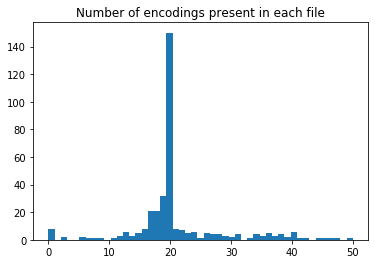

In [8]:
## see encodings distribution
enc_folder = "./encodings/"
files = os.listdir(enc_folder)
v= [] 
count = 0
for file in files:
    data = encodingsRead(enc_folder + file)
    v.append(len(data['encodings']))
    count += 1

print('Number of encondings:', count)
plt.title('Number of encodings present in each file')
plt.hist(v, bins=np.linspace(0, 50, 50))
plt.show()

Number of encondings: 354


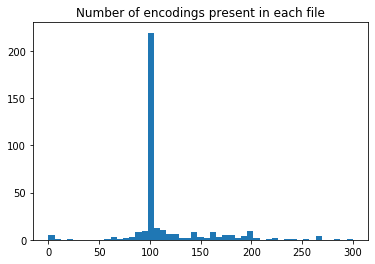

In [15]:
enc_folder = "./encodings_100/"
files = os.listdir(enc_folder)
v= [] 
count = 0
for file in files:
    data = encodingsRead(enc_folder + file)
    v.append(len(data['encodings']))
    count += 1

print('Number of encondings:', count)
plt.title('Number of encodings present in each file')
plt.hist(v, bins=np.linspace(0, 300, 50))
plt.show()

Number of encondings: 354


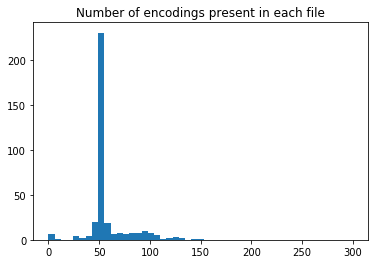

In [205]:
enc_folder = "./encodings_50/"
files = os.listdir(enc_folder)
v= [] 
count = 0
for file in files:
    data = encodingsRead(enc_folder + file)
    v.append(len(data['encodings']))
    count += 1

print('Number of encondings:', count)
plt.title('Number of encodings present in each file')
plt.hist(v, bins=np.linspace(0, 300, 50))
plt.show()

#### Labelling encodings
We are know giving a name corresponding the specific person

In [9]:
import json
target_folder = './encodings/'

file = "labelled_videos.json"
with open(file, 'r') as f:
    datastore = json.load(f)

count = 0
for person in datastore:
    print(person)
    p_count = 0
    for video in datastore[person]:
        count += 1
        name = video[:-5] + ".pkl"
        os.rename(target_folder + name, target_folder + person + "_" + str(p_count) + ".pkl")
        p_count += 1
print(count)

gregoire
damien
malory
sam
antoine
michael
sacha
juliette
christophe
jb
documents
solene
323


In [ ]:
target_folder = './encodings_100/'

file = "labelled_videos.json"
with open(file, 'r') as f:
    datastore = json.load(f)

count = 0
for person in datastore:
    print(person)
    p_count = 0
    for video in datastore[person]:
        count += 1
        name = video[:-5] + ".pkl"
        os.rename(target_folder + name, target_folder + person + "_" + str(p_count) + ".pkl")
        p_count += 1
print(count)

#### Deleting unlabeled video

In [7]:
import json
with open( root_path +'labelled_videos.json') as json_file:
    data = json.load(json_file)
    
def readTrueName(rec_name):
    for real_name in data:
        if rec_name in data[real_name]:
            return real_name
    return "unknown"

In [29]:
target_folder = "./encodings/"
files = os.listdir(target_folder)
count = 0
for file in files:
    filewebm = file[:-4] + ".webm"
    print(file)
    print(readTrueName(filewebm))
    if( readTrueName(filewebm) == None): #"unknown"):
        #os.remove(target_folder + file)
        count += 1
print(count)

rec-0048614e-6977-420f-96b9-2669e01b7b6a-xtlT3wU8hU-qR5OTs6cT0MYV1dP-1583832656032-video-face.pkl
gregoire
rec-00f2215a-653a-41b0-a2bd-e081c2644b50-G9pr1rwdts-NHrbOczHA28ELIx0-1582012854590-video-face.pkl
documents
rec-0158e178-671c-4f00-9d2c-4beb850fee5e-3JMlpKKcQI-AbKReuhN2e8lPpWU-1580377499206-video-face.pkl
juliette
rec-02775db9-2e4d-491a-ba5d-43fb715e0c3d-FA8nx738TZ-K7Nm6zOMFD0Q33Pc-1580810763795-video-face.pkl
damien
rec-029c7345-eb65-4b22-aa68-4c7ad814ec4a-YYWgaS5LEb-Wfw34uhRwl8rKOAa-1582738555620-video-face.pkl
damien
rec-03379460-9227-4a18-bc4f-5b6add8889e2-t9YIugGYEF-9ychy6UfJvPIuQhr-1583412789808-video-face.pkl
damien
rec-0343668a-4d1b-49a9-99fd-5c7b79405bb4-jjUUUmAN5N-szNTIB6uforiSTQ2-1579708266409-video-face.pkl
antoine
rec-03d368da-4518-42d2-8101-f010b0b7351e-VOG8HPCfbf-TeLbDVoK3J89n8Bx-1579700447393-video-face.pkl
gregoire
rec-0443dcfc-bca0-4a21-904e-7a9d948e873c-fmfXOCBSnf-xgSFXV1VsTFagavZ-1582046330299-video-face.pkl
gregoire
rec-050e98c2-1087-411f-96e9-b55e6bb3d268-VP

In [216]:
target_folder = "./encodings_50/"
files = os.listdir(target_folder)
count = 0
for file in files:
    filewebm = file[:-9] + ".webm"
    print(filewebm)
    print(readTrueName(filewebm))
    if( readTrueName(filewebm) == "unknown"):  #"unknown"):
        #os.remove(target_folder + file)
        count += 1
print(count)

rec-0048614e-6977-420f-96b9-2669e01b7b6a-xtlT3wU8hU-qR5OTs6cT0MYV1dP-1583832656032-video-face.webm
gregoire
rec-00f2215a-653a-41b0-a2bd-e081c2644b50-G9pr1rwdts-NHrbOczHA28ELIx0-1582012854590-video-face.webm
documents
rec-0158e178-671c-4f00-9d2c-4beb850fee5e-3JMlpKKcQI-AbKReuhN2e8lPpWU-1580377499206-video-face.webm
juliette
rec-02775db9-2e4d-491a-ba5d-43fb715e0c3d-FA8nx738TZ-K7Nm6zOMFD0Q33Pc-1580810763795-video-face.webm
damien
rec-029c7345-eb65-4b22-aa68-4c7ad814ec4a-YYWgaS5LEb-Wfw34uhRwl8rKOAa-1582738555620-video-face.webm
damien
rec-03379460-9227-4a18-bc4f-5b6add8889e2-t9YIugGYEF-9ychy6UfJvPIuQhr-1583412789808-video-face.webm
damien
rec-0343668a-4d1b-49a9-99fd-5c7b79405bb4-jjUUUmAN5N-szNTIB6uforiSTQ2-1579708266409-video-face.webm
antoine
rec-03d368da-4518-42d2-8101-f010b0b7351e-VOG8HPCfbf-TeLbDVoK3J89n8Bx-1579700447393-video-face.webm
gregoire
rec-0443dcfc-bca0-4a21-904e-7a9d948e873c-fmfXOCBSnf-xgSFXV1VsTFagavZ-1582046330299-video-face.webm
gregoire
rec-04fa96ec-03fb-418c-9718-a6dbbd

In [222]:
target_folder = "./encodings_50/"
files = os.listdir(target_folder)
count = 0
for file in files:
    filewebm = file[:-9] + ".pkl"
    os.rename(target_folder + file, target_folder + filewebm)
    count = count + 1
print(count)

323


#### Performing Test on encodings

In [12]:
def faceRecognitionENC(encodings_1, encodings_2, detection='cnn', show=False, tolerance = 0.6):
    '''
    It only works with already made encodings
    encodings_1: single encoding of the person we want to recognize
    encodings_2: encodings of the person of which we know the name
    '''
    start = time.time()

    data = encodings_2

    # initialize the list of names for each face detected
    names = []
    
    # attempt to match each encoding to our known encodings

    matches = face_recognition.compare_faces(data["encodings"],encodings_1, tolerance= tolerance)
    name = "unknown"

    # check to see if we have found a match
    if True in matches:
      # Or instead, use the known face with the smallest distance to the new face
        face_distances = face_recognition.face_distance(data["encodings"], encodings_1)
        best_match_index = np.argmin(face_distances)
        if matches[best_match_index]:
            name = data["names"][best_match_index]

    # update the list of names
    try:
        name = name.split('/')[2]
    except:
        name = name
    names.append(name)

    return names
    
def encodingsRead(path):
    data = pickle.loads(open(path, "rb").read())
    return data

In [13]:
def faceRecOnEnc(encoding_path, encodings, correct_person, detection='cnn', min_threshold = 0.85, 
                    max_threshold=0.10, show=False, tolerance = 0.6, stopping_perc = 0.50):   
    ## encoding_path -> test
    ## encodings -> train
    
    
    correct_person = readTrueName(correct_person + ".webm")
    encodings_to_compare = encodingsRead(encoding_path)
    encodings_to_compare = encodings_to_compare["encodings"]#ecoding of a different person
    
    total_frames = len(encodings_to_compare)
    min_frames = total_frames * stopping_perc / 100
    
    analysed_frames = 0
    neutrum_frames = 0
    correct_frames = 0
    negative_frames = 0
    
    start = time.time()
    
    # grab the paths to the input images in our dataset
    print("[INFO] Recognizing faces...")
    total_frames = len(encodings_to_compare)
    print("[INFO] elements:", total_frames)

    #we had some cases where no faces where recognised
    if len(encodings_to_compare) == 0:
        return False, 0, 0, 0

    #pdb.set_trace()
    # loop over the encodings
    for enc in encodings_to_compare:
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
        
        #image = imageRead(imagePath, show=False)
        person_rec = faceRecognitionENC(enc, encodings, detection='cnn', tolerance = tolerance, show=show)
        analysed_frames += 1
        
        if(len(person_rec) >= 1):
            ## modified
            print(person_rec)
            person = readTrueName(person_rec[0] + ".webm")
            if(person == correct_person):
                correct_frames += 1
            else:
                if(person == 'unknown'):
                    neutrum_frames += 1
                else:
                    negative_frames += 1
        else:
            neutrum_frames += 1
        
            
        if( analysed_frames > min_frames and correct_frames/analysed_frames > min_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            end = time.time()
            print('Time:', end-start)
            return True, correct_rate, neutrum_rate, negative_rate
        
        ######################## MODIFIED HERE
        # wrong recognition are interpreted as correspondent for this case
        #######################
        if( analysed_frames > min_frames and negative_frames/analysed_frames > min_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            end = time.time()
            print('Time:', end-start)
            return True, correct_rate, neutrum_rate, negative_rate
        
        if( analysed_frames > min_frames and (negative_frames+correct_frames)/analysed_frames < max_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            end = time.time()
            print('Time:', end-start)
            return False, correct_rate, neutrum_rate, negative_rate
        
        #########################

    #for ends
    if(total_frames == 0):
        total_frames = 1
    correct_rate = correct_frames/total_frames
    neutrum_rate = neutrum_frames/total_frames
    negative_rate = negative_frames/total_frames
    end = time.time()
    print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/total_frames)
    print('Not detected:', neutrum_frames/total_frames, ". Wrong recognition:", negative_frames/total_frames)
    print('Time:', end-start)
    if(correct_rate > min_threshold - 0.05):
        return True, correct_rate, neutrum_rate, negative_rate
    else:
        return False, correct_rate, neutrum_rate, negative_rate

In [14]:
testing_limit = 10000
encodings_folder = "./encodings/"
test_path = "./encodings_100/"
key = ""

def performCrossedTestENC(min_v=0, max_v=1000, false_threshold=0.10, true_threshold=0.85, log=False, tolerance = 0.6):
    csv = False
    stop_percentage = 40
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    start = time.time()
    count = 0
    enc_list = os.listdir(encodings_folder)
    test_dir = os.listdir(test_path)
    
    csv_folder_base = root_path
    f = open(csv_folder_base +'CrossTest' + str(tolerance) +'.csv', 'w')

    if (csv == True and f != None):
        writer = csv.writer(f)

    p_count = 0
    for encoding in enc_list:
        start_2 = time.time()    
        p_count += 1
        if( p_count > testing_limit):
            break
        count = count + 1
        if(count < min_v):
            continue
        if(count > max_v):
            break

        enc_name = encoding[0:len(encoding)-4]#removing '.pkl' from name
        encoding_path = encodings_folder + encoding
        print('[ENC] Using encoding:', enc_name)
        start_2 = time.time()
        curr_encoding = encodingsRead(encoding_path)

        if( log == True ):
            logs_folder = "./logs_" + str(tolerance) + key + "/F/"
            logfile = open(logs_folder + "log_" + enc_name + ".txt", "w")
            
        row = []
        row.append(enc_name)
        for person in test_dir:    
            if ( readTrueName(enc_name +".webm") == readTrueName(person[0:len(person)-4] +".webm") ):#removing '.pkl' from name 
                continue

            test_enc = test_path + person            
            person_name = person[0:len(person)-4]
            print('Testing on test encoding:', person)

            # test the encodings of testset               
            v, a, b, c = faceRecOnEnc(test_enc, curr_encoding, person_name, min_threshold=true_threshold,
                                         max_threshold = false_threshold, tolerance = tolerance, 
                                         stopping_perc = stop_percentage, show=False)
            if (v == True):
                row.append(person)
            if(log== True):
                line = person + " " + "0" + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                logfile.write(line)
                
        #FINE DELLA PERSONA
        if(log == True):
            logfile.close()        
        if( csv == True):
            #writing on the csv the line of all the videos in which the èerson is recognised
            writer.writerow(row)
            
        
        end_2 = time.time()    
        print("-------------------------")
        print('The comparison last:', end_2-start_2)
        print("-------------------------")
    
    end = time.time()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('This test last:', end-start)
    f.close()
    return

In [15]:

def performTestENC(min_v=0, max_v=1000, false_threshold=0.10, true_threshold=0.85, log=False, tolerance = 0.6):
    csv = False
    stop_percentage = 40
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    start = time.time()
    count = 0
    enc_list = os.listdir(encodings_folder)
    test_dir = os.listdir(test_path)
    
    csv_folder_base = root_path
    f = open(csv_folder_base +'CrossTest' + str(tolerance) +'.csv', 'w')

    if (csv == True and f != None):
        writer = csv.writer(f)
    if( log == True ):
        logs_folder = "./logs_" + str(tolerance) + key + "/T/"
        #logs_folder = "./logs/T/"
        logfile = open(logs_folder + "log_" + str(min_v) + "_" + str(max_v) + ".txt", "w")

    p_count = 0
    for encoding in enc_list:
        start_2 = time.time()    
        p_count += 1
        if( p_count > testing_limit):
            break
        count = count + 1
        if(count < min_v):
            continue
        if(count > max_v):
            break

        enc_name = encoding[0:len(encoding)-4]#removing '.pkl' from name
        encoding_path = encodings_folder + encoding
        print('[ENC] Using encoding:', enc_name)
        start_2 = time.time()
        curr_encoding = encodingsRead(encoding_path)
            
        row = []
        row.append(enc_name)
        t_count = 0
        for person in test_dir:    
            if ( readTrueName(enc_name +".webm") != readTrueName(person[0:len(person)-4] +".webm") ):#removing '.pkl' from name 
                continue

            test_enc = test_path + person            
            person_name = person[0:len(person)-4]
            print('Testing on test encoding:', person)

            # test the encodings of testset               
            v, a, b, c = faceRecOnEnc(test_enc, curr_encoding, person_name, min_threshold=true_threshold,
                                         max_threshold = false_threshold, tolerance = tolerance, 
                                         stopping_perc = stop_percentage, show=False)
            
            if (v == True):
                row.append(person)
            if(log== True):
                line = person + " " + str(t_count) + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                logfile.write(line)
            t_count += 1
                
        if( csv == True):
            #writing on the csv the line of all the videos in which the èerson is recognised
            writer.writerow(row)
            
        
        end_2 = time.time()    
        print("-------------------------")
        print('The comparison last:', end_2-start_2)
        print("-------------------------")
    #FINE DELLA PERSONA
    if(log == True):
        logfile.close()        
    
    end = time.time()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('This test last:', end-start)
    f.close()
    return

#### Test 1A
- train encoding: 20
- test encoding: 20
- tolerance: 0.5

In [ ]:
performCrossedTestENC(min_v=0, max_v=1000, false_threshold=0.20, true_threshold=0.75, tolerance = 0.5, log=True)
performTestENC(min_v=0, max_v=1000, false_threshold=0.20, true_threshold=0.75, tolerance = 0.5, log=True)

In [13]:
import os
import numpy as np
log_folder = "./logs_0.5/F/"

files = os.listdir(log_folder)


values = [0.20, 0.40, 0.45, 0.55, 0.60, 0.65, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 0.9999]
confirmed_rate = np.zeros(len(values))
i = 0

for thr in values:
    total_files = 0
    recognized = 0
    notdetected = 0
    wrong = 0
    wrong_confirmed = 0
    wrong_confirmed2 = 0
    wrong_confirmed3 = 0
    wrong_confirmed4 = 0

    ####
    one_wrong_rec = 0
    persons = 0
    for f in files:
        if( f.startswith('log') == True):
            filev = open(log_folder + f, "r")
            vector = f.split('_')[1].split(".")[0]
            correct_person = readTrueName(vector + ".webm")
            lines = filev.readlines()
            persons += 1
            for line in lines: 
                #we don't want to make statistics on the same person
                name = line.split(' ')[0] + ".webm"
                if(readTrueName(name) == correct_person):
                    continue

                total_files += 1

                rec_flag = line.split(' ')[2]
                rec_percentage = float(line.split(' ')[3])
                notdec_percentage = float(line.split(' ')[4])
                notrec_percentage = float(line.split(' ')[5])

                recognized = recognized + rec_percentage
                notdetected = notdetected + notdec_percentage
                wrong = wrong + notrec_percentage

                if(notrec_percentage > thr):
                    wrong_confirmed = wrong_confirmed + 1
    
    if(total_files == 0):
        total_files = 1
    confirmed_rate[i] = wrong_confirmed / total_files
    wrong_confirmed = 0
    i = i +1

## equal for each iteration
positive = recognized / total_files 
undetected = notdetected / total_files
negative = wrong / total_files

wrong_rec_on_persons = one_wrong_rec / (persons-1)
json_file.close()


Percentage of overall images that were correctly not recognized: 0.9860066578916088


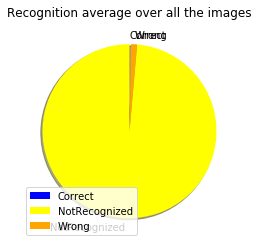

Percentage of people wrongly confirmed using threshold 0.65 is: 0.003993717747363698


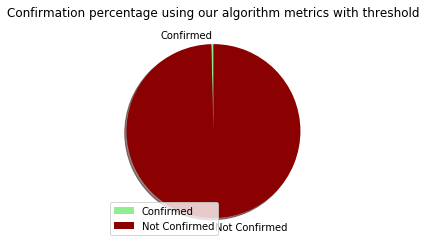

Percentage of people wrongly confirmed using threshold 0.75 is: 0.0035898586493156833


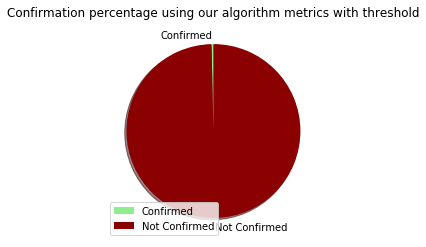

Percentage of people wrongly confirmed using threshold 0.8 is: 0.0029391967691272157


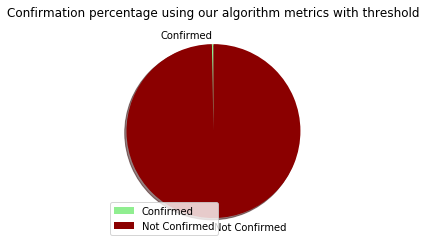

Percentage of people wrongly confirmed using threshold 0.85 is: 0.002815795378056989


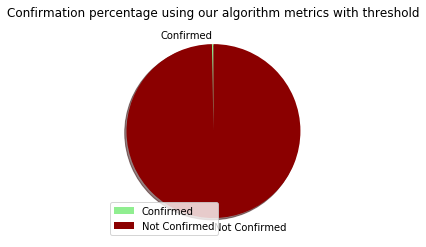

Percentage of people wrongly confirmed using threshold 0.9 is: 0.002176351806147633


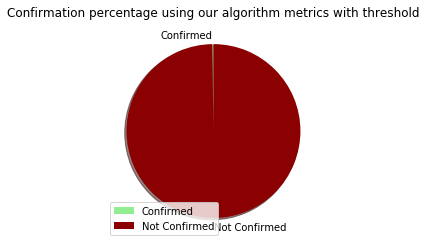

Percentage of people wrongly confirmed using threshold 0.95 is: 0.0020978236481938523


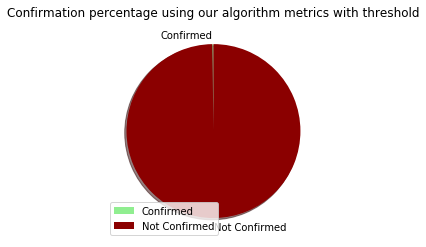

Percentage of people wrongly confirmed using threshold 0.99 is: 0.0020978236481938523


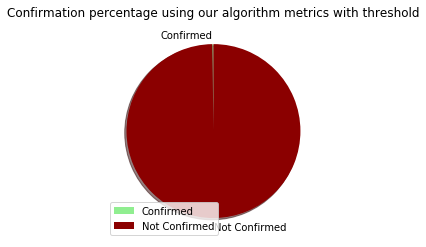

Percentage of people wrongly confirmed using threshold 0.9999 is: 0.0020978236481938523


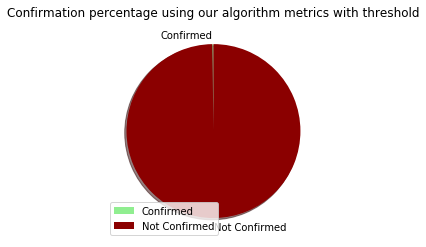

In [14]:
## WRONG ONES WHERE ASSIGNED TO THE PERSON EVEN HE WASN'T

labels = ['Correct', 'NotRecognized', 'Wrong']
colors = ['Blue', 'Yellow', 'Orange']
sizes1 = [positive, undetected, negative]
print('Percentage of overall images that were correctly not recognized:', undetected)

plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()

fpr = np.zeros(4)
i =0
for cfr in confirmed_rate:
    if( i < 5 ):
        i = i +1
        continue
    labels = ['Confirmed', 'Not Confirmed']
    colors = ['Lightgreen', 'Darkred']
    sizes1 = [cfr, (1 - cfr)]
    print('Percentage of people wrongly confirmed using threshold', values[i], 'is:', cfr)

    plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
    plt.title('Confirmation percentage using our algorithm metrics with threshold')
    plt.legend()
    plt.show()
    i = i +1

In [15]:
import numpy as np
TAR_path = "./logs_0.5/T/"

import os
files = os.listdir(TAR_path)
confirmed_rateT = np.zeros(len(values))
i=0

for thr in values:
    total_files = 0
    recognized = 0
    notdetected = 0
    wrong = 0
    confirmed = 0
    total_files = 0
    
    for f in files:
        if( f.startswith('log') == True):
            filev = open(TAR_path + f, "r")
            lines = filev.readlines()
            for line in lines:
                total_files += 1

                rec_flag = line.split(' ')[2]
                rec_percentage = float(line.split(' ')[3])
                notdec_percentage = float(line.split(' ')[4])
                notrec_percentage = float(line.split(' ')[5])

                recognized = recognized + rec_percentage
                notdetected = notdetected + notdec_percentage
                wrong = wrong + notrec_percentage
                if(rec_percentage > thr):
                    confirmed = confirmed + 1

    confirmed_rateT[i] = confirmed / total_files
    
    positive = recognized / total_files 
    undetected = notdetected / total_files
    negative = wrong / total_files
    
    i = i + 1

Percentage of TAR using threshold 0.65 is 0.7384291263414313


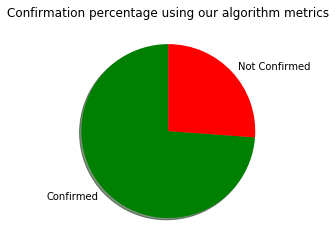

Percentage of TAR using threshold 0.75 is 0.7060372638093357


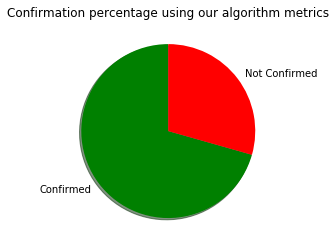

Percentage of TAR using threshold 0.8 is 0.6157745737046547


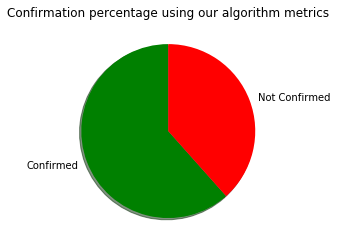

Percentage of TAR using threshold 0.85 is 0.6085983277371783


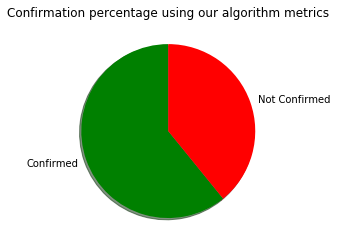

Percentage of TAR using threshold 0.9 is 0.4887747712160116


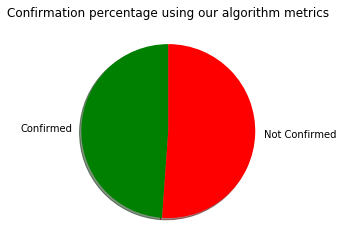

Percentage of TAR using threshold 0.95 is 0.4814668510105998


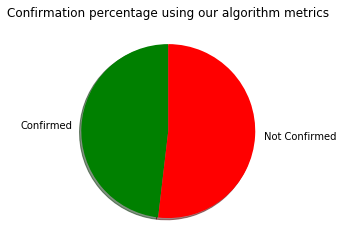

Percentage of TAR using threshold 0.99 is 0.4811376654157614


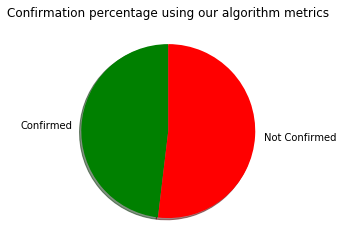

Percentage of TAR using threshold 0.9999 is 0.4811376654157614


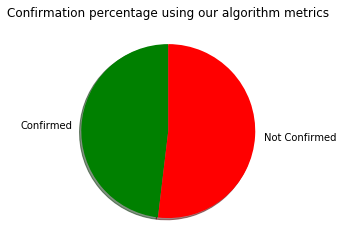

In [16]:
i = 0
for cfr in confirmed_rateT:
    if( i < 5 ):
        i = i +1
        continue
    labels = ['Confirmed', 'Not Confirmed']
    colors = ['Green', 'Red']
    sizes1 = [cfr, (1 - cfr)]
    print('Percentage of TAR using threshold', values[i], 'is', cfr)
    i = i+ 1

    plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
    plt.title('Confirmation percentage using our algorithm metrics')
    plt.show()

Embeddings train: 20
Embeddings test: 20
Tolerance: 0.5


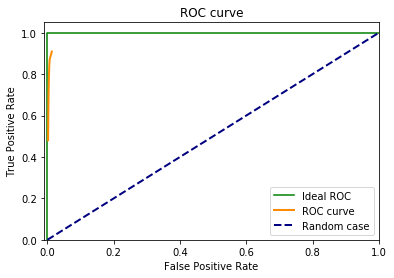

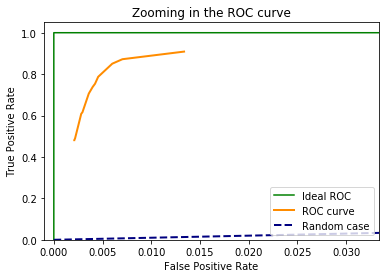

In [17]:
from sklearn.metrics import roc_curve, auc
print("Embeddings train: 20")
print("Embeddings test: 20")
print("Tolerance: 0.5")
fpr = confirmed_rate
tpr = confirmed_rateT
exampleX = [0.0, 0.0000001, 0.2, 0.8, 1.0]
exampleY = [0.0, 1.0, 1.0, 1.0, 1.0]
limitx = np.max(fpr)

plt.figure()
lw = 2
plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

plt.figure()
lw = 2
plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
plt.xlim([-0.001, limitx+0.02])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zooming in the ROC curve')
plt.legend(loc="lower right")
plt.show()


#### Test 1B
- train encoding: 20
- test encoding: 20
- tolerance: 0.6

In [ ]:
performCrossedTestENC(min_v=0, max_v=1000, false_threshold=0.20, true_threshold=0.75, tolerance = 0.6, log=True)
performTestENC(min_v=0, max_v=1000, false_threshold=0.20, true_threshold=0.75, tolerance = 0.6, log=True)

In [18]:
import os
import numpy as np
log_folder = "./logs_0.6/F/"

files = os.listdir(log_folder)


values = [0.20, 0.40, 0.45, 0.55, 0.60, 0.65, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 0.9999]
confirmed_rate = np.zeros(len(values))
i = 0

for thr in values:
    total_files = 0
    recognized = 0
    notdetected = 0
    wrong = 0
    wrong_confirmed = 0
    wrong_confirmed2 = 0
    wrong_confirmed3 = 0
    wrong_confirmed4 = 0

    ####
    one_wrong_rec = 0
    persons = 0
    for f in files:
        if( f.startswith('log') == True):
            filev = open(log_folder + f, "r")
            vector = f.split('_')[1].split(".")[0]
            correct_person = readTrueName(vector + ".webm")
            lines = filev.readlines()
            persons += 1
            for line in lines: 
                #we don't want to make statistics on the same person
                name = line.split(' ')[0] + ".webm"
                if(readTrueName(name) == correct_person):
                    continue

                total_files += 1

                rec_flag = line.split(' ')[2]
                rec_percentage = float(line.split(' ')[3])
                notdec_percentage = float(line.split(' ')[4])
                notrec_percentage = float(line.split(' ')[5])

                recognized = recognized + rec_percentage
                notdetected = notdetected + notdec_percentage
                wrong = wrong + notrec_percentage

                if(notrec_percentage > thr):
                    wrong_confirmed = wrong_confirmed + 1
    
    if(total_files == 0):
        total_files = 1
    confirmed_rate[i] = wrong_confirmed / total_files
    wrong_confirmed = 0
    i = i +1

## equal for each iteration
positive = recognized / total_files 
undetected = notdetected / total_files
negative = wrong / total_files

wrong_rec_on_persons = one_wrong_rec / (persons-1)
json_file.close()


In [19]:
import numpy as np
TAR_path = "./logs_0.6/T/"

import os
files = os.listdir(TAR_path)
confirmed_rateT = np.zeros(len(values))
i=0

for thr in values:
    total_files = 0
    recognized = 0
    notdetected = 0
    wrong = 0
    confirmed = 0
    total_files = 0
    
    for f in files:
        if( f.startswith('log') == True):
            filev = open(TAR_path + f, "r")
            lines = filev.readlines()
            for line in lines:
                total_files += 1

                rec_flag = line.split(' ')[2]
                rec_percentage = float(line.split(' ')[3])
                notdec_percentage = float(line.split(' ')[4])
                notrec_percentage = float(line.split(' ')[5])

                recognized = recognized + rec_percentage
                notdetected = notdetected + notdec_percentage
                wrong = wrong + notrec_percentage
                if(rec_percentage > thr):
                    confirmed = confirmed + 1

    confirmed_rateT[i] = confirmed / total_files
    
    positive = recognized / total_files 
    undetected = notdetected / total_files
    negative = wrong / total_files
    
    i = i + 1

Embeddings train: 20
Embeddings test: 20
Tolerance: 0.6


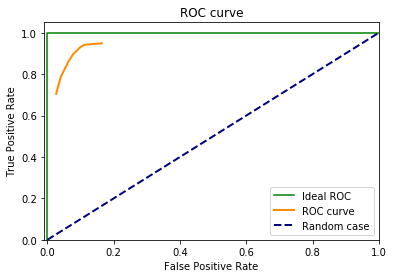

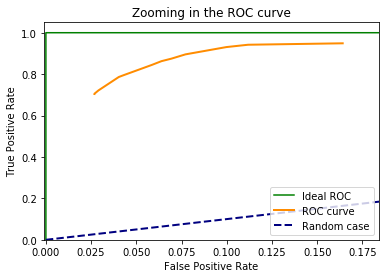

In [20]:
from sklearn.metrics import roc_curve, auc
print("Embeddings train: 20")
print("Embeddings test: 20")
print("Tolerance: 0.6")
fpr = confirmed_rate
tpr = confirmed_rateT
exampleX = [0.0, 0.0000001, 0.2, 0.8, 1.0]
exampleY = [0.0, 1.0, 1.0, 1.0, 1.0]
limitx = np.max(fpr)

plt.figure()
lw = 2
plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

plt.figure()
lw = 2
plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
plt.xlim([-0.001, limitx+0.02])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zooming in the ROC curve')
plt.legend(loc="lower right")
plt.show()

#### Test 1C
- train encoding: 20
- test encoding: 20
- tolerance: 0.4

In [ ]:
performCrossedTestENC(min_v=0, max_v=1000, false_threshold=0.20, true_threshold=0.75, tolerance = 0.4, log=True)
performTestENC(min_v=0, max_v=1000, false_threshold=0.20, true_threshold=0.75, tolerance = 0.4, log=True)

In [200]:
import os
import numpy as np
log_folder = "./logs_0.5/F/"

files = os.listdir(log_folder)


values = [0.20, 0.40, 0.45, 0.55, 0.60, 0.65, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 0.9999]
confirmed_rate = np.zeros(len(values))
i = 0

for thr in values:
    total_files = 0
    recognized = 0
    notdetected = 0
    wrong = 0
    wrong_confirmed = 0
    wrong_confirmed2 = 0
    wrong_confirmed3 = 0
    wrong_confirmed4 = 0

    ####
    one_wrong_rec = 0
    persons = 0
    for f in files:
        if( f.startswith('log') == True):
            filev = open(log_folder + f, "r")
            vector = f.split('_')[1].split(".")[0]
            correct_person = readTrueName(vector + ".webm")
            lines = filev.readlines()
            persons += 1
            for line in lines: 
                #we don't want to make statistics on the same person
                name = line.split(' ')[0] + ".webm"
                if(readTrueName(name) == correct_person):
                    continue

                total_files += 1

                rec_flag = line.split(' ')[2]
                rec_percentage = float(line.split(' ')[3])
                notdec_percentage = float(line.split(' ')[4])
                notrec_percentage = float(line.split(' ')[5])

                recognized = recognized + rec_percentage
                notdetected = notdetected + notdec_percentage
                wrong = wrong + notrec_percentage

                if(notrec_percentage > thr):
                    wrong_confirmed = wrong_confirmed + 1
    
    if(total_files == 0):
        total_files = 1
    confirmed_rate[i] = wrong_confirmed / total_files
    wrong_confirmed = 0
    i = i +1

## equal for each iteration
positive = recognized / total_files 
undetected = notdetected / total_files
negative = wrong / total_files

wrong_rec_on_persons = one_wrong_rec / (persons-1)
json_file.close()

Percentage of people wrongly confirmed using threshold 0.65 is: 0.004621735618774118


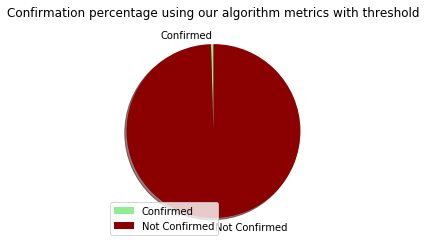

Percentage of people wrongly confirmed using threshold 0.75 is: 0.004229112447276317


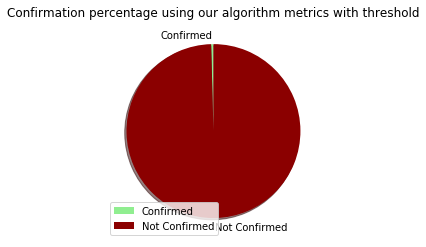

Percentage of people wrongly confirmed using threshold 0.8 is: 0.0035896975679798977


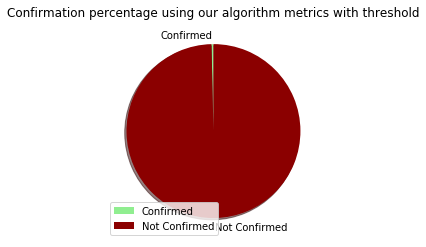

Percentage of people wrongly confirmed using threshold 0.85 is: 0.0034887373238804632


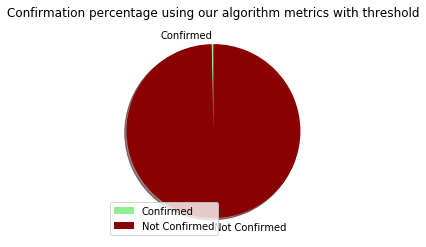

Percentage of people wrongly confirmed using threshold 0.9 is: 0.0028493224445840437


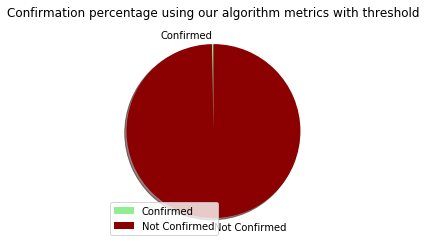

Percentage of people wrongly confirmed using threshold 0.95 is: 0.0027707978102844834


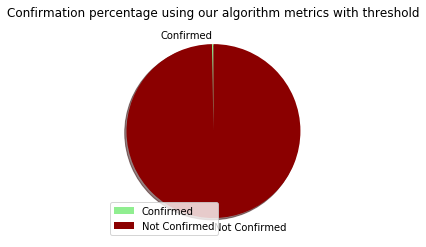

Percentage of people wrongly confirmed using threshold 0.99 is: 0.0027707978102844834


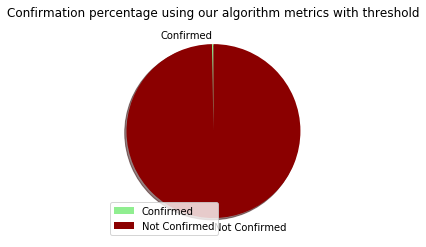

Percentage of people wrongly confirmed using threshold 0.9999 is: 0.0027707978102844834


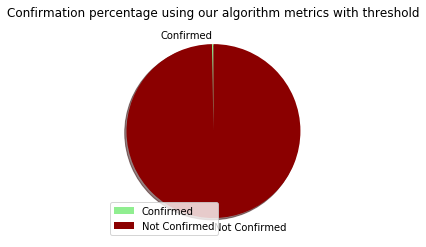

In [201]:
fpr = np.zeros(4)
i =0
for cfr in confirmed_rate:
    if( i < 5 ):
        i = i +1
        continue
    labels = ['Confirmed', 'Not Confirmed']
    colors = ['Lightgreen', 'Darkred']
    sizes1 = [cfr, (1 - cfr)]
    print('Percentage of people wrongly confirmed using threshold', values[i], 'is:', cfr)

    plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
    plt.title('Confirmation percentage using our algorithm metrics with threshold')
    plt.legend()
    plt.show()
    i = i +1

In [202]:
import numpy as np
TAR_path = "./logs_0.4/T/"

import os
files = os.listdir(TAR_path)
confirmed_rateT = np.zeros(len(values))
i=0

for thr in values:
    total_files = 0
    recognized = 0
    notdetected = 0
    wrong = 0
    confirmed = 0
    total_files = 0
    
    for f in files:
        if( f.startswith('log') == True):
            filev = open(TAR_path + f, "r")
            lines = filev.readlines()
            for line in lines:
                total_files += 1

                rec_flag = line.split(' ')[2]
                rec_percentage = float(line.split(' ')[3])
                notdec_percentage = float(line.split(' ')[4])
                notrec_percentage = float(line.split(' ')[5])

                recognized = recognized + rec_percentage
                notdetected = notdetected + notdec_percentage
                wrong = wrong + notrec_percentage
                if(rec_percentage > thr):
                    confirmed = confirmed + 1

    confirmed_rateT[i] = confirmed / total_files
    
    positive = recognized / total_files 
    undetected = notdetected / total_files
    negative = wrong / total_files
    
    i = i + 1

Percentage of TAR using threshold 0.65 is 0.453551912568306


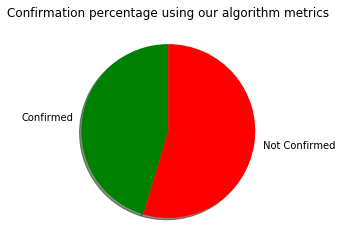

Percentage of TAR using threshold 0.75 is 0.42385937191388506


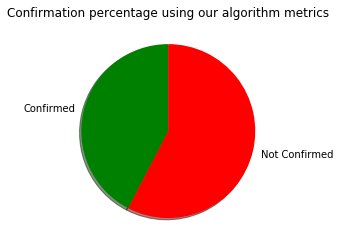

Percentage of TAR using threshold 0.8 is 0.3309631970504971


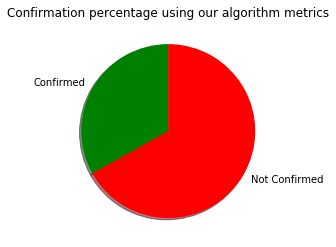

Percentage of TAR using threshold 0.85 is 0.32793468957798405


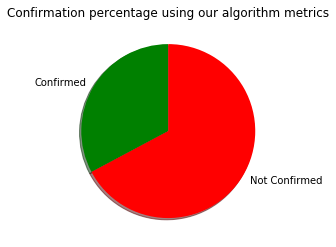

Percentage of TAR using threshold 0.9 is 0.24544077951148857


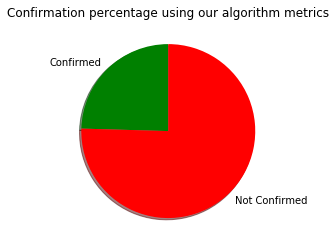

Percentage of TAR using threshold 0.95 is 0.24254394627691092


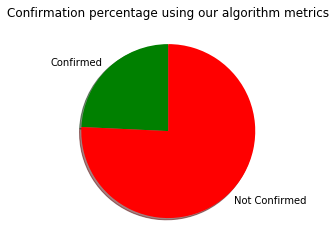

Percentage of TAR using threshold 0.99 is 0.24254394627691092


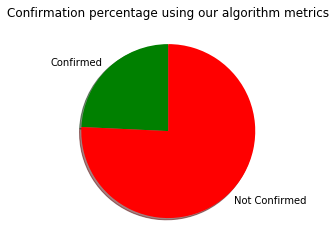

Percentage of TAR using threshold 0.9999 is 0.24254394627691092


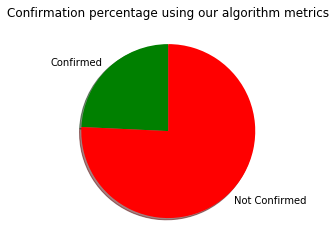

In [203]:
i = 0
for cfr in confirmed_rateT:
    if( i < 5 ):
        i = i +1
        continue
    labels = ['Confirmed', 'Not Confirmed']
    colors = ['Green', 'Red']
    sizes1 = [cfr, (1 - cfr)]
    print('Percentage of TAR using threshold', values[i], 'is', cfr)
    i = i+ 1

    plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
    plt.title('Confirmation percentage using our algorithm metrics')
    plt.show()

Embeddings train: 20
Embeddings test: 20
Tolerance: 0.4


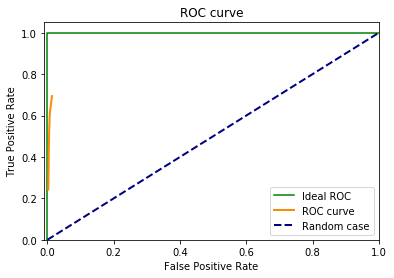

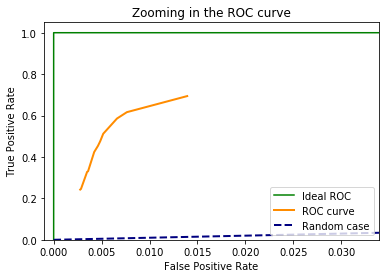

In [204]:
from sklearn.metrics import roc_curve, auc
print("Embeddings train: 20")
print("Embeddings test: 20")
print("Tolerance: 0.4")
fpr = confirmed_rate
tpr = confirmed_rateT
exampleX = [0.0, 0.0000001, 0.2, 0.8, 1.0]
exampleY = [0.0, 1.0, 1.0, 1.0, 1.0]
limitx = np.max(fpr)

plt.figure()
lw = 2
plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

plt.figure()
lw = 2
plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
plt.xlim([-0.001, limitx+0.02])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zooming in the ROC curve')
plt.legend(loc="lower right")
plt.show()

#### Test 2A
- train encoding: 20
- test encoding: 50
- tolerance: 0.5

In [223]:
encodings_folder = "./encodings/"
test_path = "./encodings_50/"
key = "_50"

In [ ]:
performTestENC(min_v=0, max_v=1000, false_threshold=0.20, true_threshold=0.75, tolerance = 0.5, log=True)
performCrossedTestENC(min_v=0, max_v=1000, false_threshold=0.20, true_threshold=0.75, tolerance = 0.5, log=True)

In [ ]:
import os
import numpy as np
log_folder = "./logs/"

files = os.listdir(log_folder)


values = [0.0, 0.45, 0.50, 0.55, 0.60, 0.65, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 0.9999]
confirmed_rate = np.zeros(len(values))
i = 0

for thr in values:
    total_files = 0
    recognized = 0
    notdetected = 0
    wrong = 0
    wrong_confirmed = 0
    wrong_confirmed2 = 0
    wrong_confirmed3 = 0
    wrong_confirmed4 = 0

    ####
    one_wrong_rec = 0
    persons = 0
    for f in files:
        if( f.startswith('log') == True):
            filev = open(log_folder + f, "r")
            vector = f.split('_')
            correct_person = vector[1] + "_" + vector[2]
            lines = filev.readlines()
            persons += 1
            for line in lines: 
                #we don't want to make statistics on the same person
                if(line.split(' ')[0] == correct_person):
                    continue

                total_files += 1

                rec_flag = line.split(' ')[2]
                rec_percentage = float(line.split(' ')[3])
                notdec_percentage = float(line.split(' ')[4])
                notrec_percentage = float(line.split(' ')[5])

                recognized = recognized + rec_percentage
                notdetected = notdetected + notdec_percentage
                wrong = wrong + notrec_percentage

                if(notrec_percentage > thr):
                    wrong_confirmed = wrong_confirmed + 1

    confirmed_rate[i] = wrong_confirmed / total_files
    wrong_confirmed = 0
    i = i +1

## equal for each iteration
positive = recognized / total_files 
undetected = notdetected / total_files
negative = wrong / total_files

wrong_rec_on_persons = one_wrong_rec / (persons-1)

In [ ]:
fpr = np.zeros(4)
i =0
for cfr in confirmed_rate:
    if( i < 5 ):
        i = i +1
        continue
    labels = ['Confirmed', 'Not Confirmed']
    colors = ['Lightgreen', 'Darkred']
    sizes1 = [cfr, (1 - cfr)]
    print('Percentage of people wrongly confirmed using threshold', values[i], 'is:', cfr)

    plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
    plt.title('Confirmation percentage using our algorithm metrics with threshold')
    plt.legend()
    plt.show()
    i = i +1

In [225]:
import numpy as np
TAR_path = "./logs_0.5_50/T/"

import os
files = os.listdir(TAR_path)
confirmed_rateT = np.zeros(len(values))
i=0

for thr in values:
    total_files = 0
    recognized = 0
    notdetected = 0
    wrong = 0
    confirmed = 0
    total_files = 0
    
    for f in files:
        if( f.startswith('log') == True):
            filev = open(TAR_path + f, "r")
            lines = filev.readlines()
            for line in lines:
                total_files += 1

                rec_flag = line.split(' ')[2]
                rec_percentage = float(line.split(' ')[3])
                notdec_percentage = float(line.split(' ')[4])
                notrec_percentage = float(line.split(' ')[5])

                recognized = recognized + rec_percentage
                notdetected = notdetected + notdec_percentage
                wrong = wrong + notrec_percentage
                if(rec_percentage > thr):
                    confirmed = confirmed + 1

    confirmed_rateT[i] = confirmed / total_files
    
    positive = recognized / total_files 
    undetected = notdetected / total_files
    negative = wrong / total_files
    
    i = i + 1

#### Test 2B
- train encoding: 20
- test encoding: 50
- tolerance: 0.6

In [17]:
import os
import numpy as np
log_folder = "./logs_0.6_50/F/"

files = os.listdir(log_folder)


values = [0.20, 0.40, 0.45, 0.55, 0.60, 0.65, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 0.9999]
confirmed_rate = np.zeros(len(values))
i = 0

for thr in values:
    total_files = 0
    recognized = 0
    notdetected = 0
    wrong = 0
    wrong_confirmed = 0
    wrong_confirmed2 = 0
    wrong_confirmed3 = 0
    wrong_confirmed4 = 0

    ####
    one_wrong_rec = 0
    persons = 0
    for f in files:
        if( f.startswith('log') == True):
            filev = open(log_folder + f, "r")
            vector = f.split('_')[1].split(".")[0]
            correct_person = readTrueName(vector + ".webm")
            lines = filev.readlines()
            persons += 1
            for line in lines: 
                #we don't want to make statistics on the same person
                name = line.split(' ')[0] + ".webm"
                if(readTrueName(name) == correct_person):
                    continue

                total_files += 1

                rec_flag = line.split(' ')[2]
                rec_percentage = float(line.split(' ')[3])
                notdec_percentage = float(line.split(' ')[4])
                notrec_percentage = float(line.split(' ')[5])

                recognized = recognized + rec_percentage
                notdetected = notdetected + notdec_percentage
                wrong = wrong + notrec_percentage

                if(notrec_percentage > thr):
                    wrong_confirmed = wrong_confirmed + 1
    
    if(total_files == 0):
        total_files = 1
    confirmed_rate[i] = wrong_confirmed / total_files
    wrong_confirmed = 0
    i = i +1

## equal for each iteration
positive = recognized / total_files 
undetected = notdetected / total_files
negative = wrong / total_files

wrong_rec_on_persons = one_wrong_rec / (persons-1)

In [18]:
import numpy as np
TAR_path = "./logs_0.6_50/T/"

import os
files = os.listdir(TAR_path)
confirmed_rateT = np.zeros(len(values))
i=0

for thr in values:
    total_files = 0
    recognized = 0
    notdetected = 0
    wrong = 0
    confirmed = 0
    total_files = 0
    
    for f in files:
        if( f.startswith('log') == True):
            filev = open(TAR_path + f, "r")
            lines = filev.readlines()
            for line in lines:
                total_files += 1

                rec_flag = line.split(' ')[2]
                rec_percentage = float(line.split(' ')[3])
                notdec_percentage = float(line.split(' ')[4])
                notrec_percentage = float(line.split(' ')[5])

                recognized = recognized + rec_percentage
                notdetected = notdetected + notdec_percentage
                wrong = wrong + notrec_percentage
                if(rec_percentage > thr):
                    confirmed = confirmed + 1

    confirmed_rateT[i] = confirmed / total_files
    
    positive = recognized / total_files 
    undetected = notdetected / total_files
    negative = wrong / total_files
    
    i = i + 1

Embeddings train: 20
Embeddings test: 50
Tolerance: 0.6


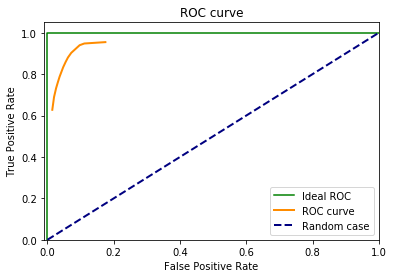

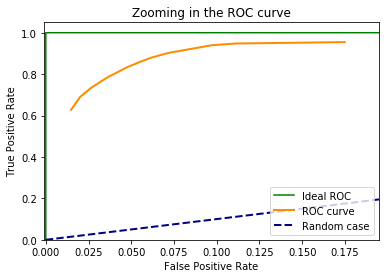

In [19]:
from sklearn.metrics import roc_curve, auc
print("Embeddings train: 20")
print("Embeddings test: 50")
print("Tolerance: 0.6")
fpr = confirmed_rate
tpr = confirmed_rateT
exampleX = [0.0, 0.0000001, 0.2, 0.8, 1.0]
exampleY = [0.0, 1.0, 1.0, 1.0, 1.0]
limitx = np.max(fpr)

plt.figure()
lw = 2
plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

plt.figure()
lw = 2
plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
plt.xlim([-0.001, limitx+0.02])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zooming in the ROC curve')
plt.legend(loc="lower right")
plt.show()

#### Test 2C
- train encoding: 20
- test encoding: 50
- tolerance: 0.55

In [16]:
import os
import numpy as np
log_folder = "./logs_0.55_50/F/"

files = os.listdir(log_folder)


values = [0.20, 0.40, 0.45, 0.55, 0.60, 0.65, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 0.9999]
confirmed_rate = np.zeros(len(values))
i = 0

for thr in values:
    total_files = 0
    recognized = 0
    notdetected = 0
    wrong = 0
    wrong_confirmed = 0
    wrong_confirmed2 = 0
    wrong_confirmed3 = 0
    wrong_confirmed4 = 0

    ####
    one_wrong_rec = 0
    persons = 0
    for f in files:
        if( f.startswith('log') == True):
            filev = open(log_folder + f, "r")
            vector = f.split('_')[1].split(".")[0]
            correct_person = readTrueName(vector + ".webm")
            lines = filev.readlines()
            persons += 1
            for line in lines: 
                #we don't want to make statistics on the same person
                name = line.split(' ')[0] + ".webm"
                if(readTrueName(name) == correct_person):
                    continue

                total_files += 1

                rec_flag = line.split(' ')[2]
                rec_percentage = float(line.split(' ')[3])
                notdec_percentage = float(line.split(' ')[4])
                notrec_percentage = float(line.split(' ')[5])

                recognized = recognized + rec_percentage
                notdetected = notdetected + notdec_percentage
                wrong = wrong + notrec_percentage

                if(notrec_percentage > thr):
                    wrong_confirmed = wrong_confirmed + 1
    
    if(total_files == 0):
        total_files = 1
    confirmed_rate[i] = wrong_confirmed / total_files
    wrong_confirmed = 0
    i = i +1

## equal for each iteration
positive = recognized / total_files 
undetected = notdetected / total_files
negative = wrong / total_files

wrong_rec_on_persons = one_wrong_rec / (persons-1)

In [17]:
import numpy as np
TAR_path = "./logs_0.55_50/T/"

import os
files = os.listdir(TAR_path)
confirmed_rateT = np.zeros(len(values))
i=0

for thr in values:
    total_files = 0
    recognized = 0
    notdetected = 0
    wrong = 0
    confirmed = 0
    total_files = 0
    
    for f in files:
        if( f.startswith('log') == True):
            filev = open(TAR_path + f, "r")
            lines = filev.readlines()
            for line in lines:
                total_files += 1

                rec_flag = line.split(' ')[2]
                rec_percentage = float(line.split(' ')[3])
                notdec_percentage = float(line.split(' ')[4])
                notrec_percentage = float(line.split(' ')[5])

                recognized = recognized + rec_percentage
                notdetected = notdetected + notdec_percentage
                wrong = wrong + notrec_percentage
                if(rec_percentage > thr):
                    confirmed = confirmed + 1

    confirmed_rateT[i] = confirmed / total_files
    
    positive = recognized / total_files 
    undetected = notdetected / total_files
    negative = wrong / total_files
    
    i = i + 1

Embeddings train: 20
Embeddings test: 50
Tolerance: 0.55


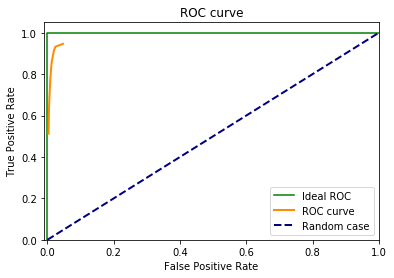

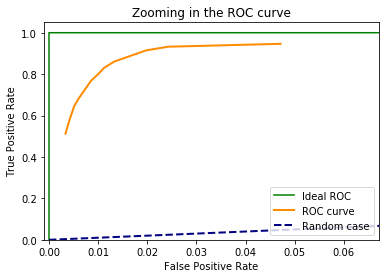

In [19]:
from sklearn.metrics import roc_curve, auc
print("Embeddings train: 20")
print("Embeddings test: 50")
print("Tolerance: 0.55")
fpr = confirmed_rate
tpr = confirmed_rateT
exampleX = [0.0, 0.0000001, 0.2, 0.8, 1.0]
exampleY = [0.0, 1.0, 1.0, 1.0, 1.0]
limitx = np.max(fpr)

plt.figure()
lw = 2
plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

plt.figure()
lw = 2
plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
plt.xlim([-0.001, limitx+0.02])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zooming in the ROC curve')
plt.legend(loc="lower right")
plt.show()